In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from dbesg import SmithWilson, NelsonSiegel, DynamicNelsonSiegel

In [2]:
# 환경설정
np.random.seed(20200109)
font_name = matplotlib.font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
matplotlib.rcParams['axes.unicode_minus'] = False
krfont = {'family':font_name, 'size':10}
matplotlib.rc('font', **krfont)
plt.style.use("ggplot")
pd.options.display.float_format = '{:,.3f}'.format

In [3]:
# 데이터 불러오기
data = pd.read_excel('./data/D_Bond_Mark_to_Mkt_Benchmark_Yields_TS_200109102310.xlsx')
data.columns = data.iloc[2].values
data = data.iloc[3:].reset_index(drop=True).sort_values(by='일자')
data.head()

,일자,3개월,6개월,9개월,12개월,18개월,24개월,30개월,3년,4년,5년,7년,10년,20년,30년,50년
0,2010.01.08,2.290,2.900,3.180,3.420,3.830,4.240,4.310,4.350,NaN,4.910,5.210,5.370,5.570,NaN,NaN
1,2010.01.15,2.250,2.790,3.040,3.280,3.760,4.130,4.190,4.240,NaN,4.800,5.160,5.380,5.560,NaN,NaN
2,2010.01.22,2.350,2.820,3.050,3.280,3.710,4.060,4.190,4.240,NaN,4.800,5.140,5.330,5.530,NaN,NaN
3,2010.01.29,2.370,2.780,3.030,3.260,3.680,3.990,4.190,4.270,NaN,4.820,5.120,5.340,5.490,NaN,NaN
4,2010.02.05,2.190,2.610,2.930,3.180,3.600,3.890,4.120,4.210,NaN,4.780,5.070,5.320,5.470,NaN,NaN


In [178]:
# 분석용 데이터
base_date = '2020.01.03'
# base_date = '2020.01.03'
end = data.loc[data['일자'] == base_date].index.values[0]
start = end-416
data_selected = data.iloc[start:end+1].reset_index(drop=True)

In [179]:
data_selected.iloc[-2:][['일자', '12개월', '24개월', '3년', '5년', '10년', '20년']]

,일자,12개월,24개월,3년,5년,10년,20년
415,2019.12.27,1.342,1.377,1.365,1.485,1.682,1.690
416,2020.01.03,1.287,1.290,1.272,1.362,1.560,1.585


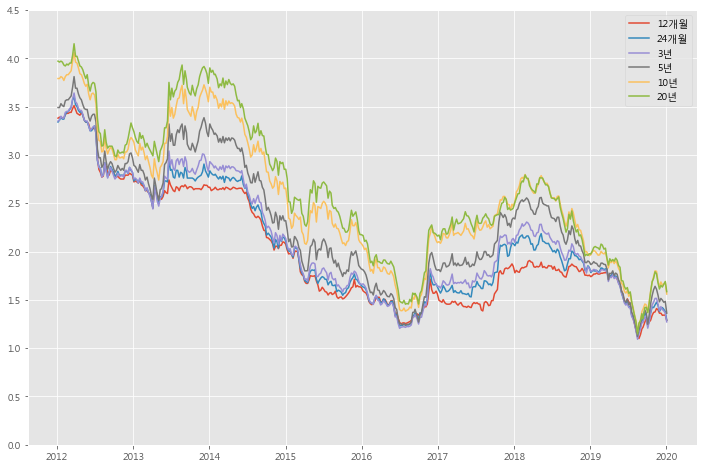

In [209]:
plt.figure(figsize=(12,8))
for i in ['12개월', '24개월', '3년', '5년', '10년', '20년']:
    plt.plot(pd.to_datetime(data_selected['일자']), data_selected[i].astype(float), label=i)
plt.legend()
plt.ylim(0, 4.5)
plt.show()

In [180]:
# 훈련용 데이터
X_train = np.array(data_selected[['12개월', '24개월', '3년', '5년', '10년', '20년']].astype(float)/100)
maturity = np.array([1, 2, 3, 5, 10, 20])
dt = 1/52

In [181]:
# 훈련
dns = DynamicNelsonSiegel(dt, maturity)
dns.train(X_train)

In [182]:
dns._initial_value(X_train)

array([ 6.23182595e-01,  2.35273456e-04,  3.42102913e-01,  1.25996260e+00,
        1.74860717e+00,  1.90268786e-02, -7.51571622e-03, -8.93739039e-03,
        5.65604935e-03, -5.79012298e-03,  4.05694311e-03, -5.11855740e-04,
       -7.03738948e-03,  9.40289749e-03])

In [183]:
dns._filtering(dns._initial_value(X_train), X_train)[0]

array([ 0.01705712, -0.00321985, -0.00866011])

In [184]:
dns._filtering(dns._initial_value(X_train), X_train)[2]

17584.542688853202

In [185]:
dns.params

array([ 6.27264710e-01,  2.98610006e-04,  4.15384114e-01,  9.12811872e-01,
        5.08888270e-01,  2.23577097e-02, -8.14729489e-03, -8.32228171e-03,
        5.39708735e-03, -4.79914101e-03,  2.65965456e-03, -8.54985380e-04,
       -2.75759706e-03,  6.46545831e-03])

In [186]:
dns._filtering(dns.params, X_train)[0]

array([ 0.01688612, -0.0034411 , -0.00738308])

In [187]:
dns._filtering(dns.params, X_train)[2]

17733.113402068284

In [188]:
# 주 추정
x_1W, Q_1W, z_1W, R_1W, state_1W, measurement_1W = dns.generate(1/52, 200)

In [189]:
# 월 추정
x_1M, Q_1M, z_1M, R_1M, state_1M, measurement_1M = dns.generate(1/12, 200)

In [190]:
# 분기 추정
x_1Q, Q_1Q, z_1Q, R_1Q, state_1Q, measurement_1Q = dns.generate(1/4, 200)

In [191]:
# 반기 추정
x_1H, Q_1H, z_1H, R_1H, state_1H, measurement_1H = dns.generate(1/2, 200)

In [192]:
# 연 추정
x_1Y, Q_1Y, z_1Y, R_1Y, state_1Y, measurement_1Y = dns.generate(1, 200)

In [195]:
print(np.round((X_train[-1])*100,3))

[1.287 1.29  1.272 1.362 1.56  1.585]


In [193]:
print(np.round((X_train[-1]+z_1W-dns.H@dns.x0)*100,3))
print(np.round((X_train[-1]+z_1M-dns.H@dns.x0)*100,3))
print(np.round((X_train[-1]+z_1Q-dns.H@dns.x0)*100,3))
print(np.round((X_train[-1]+z_1H-dns.H@dns.x0)*100,3))
print(np.round((X_train[-1]+z_1Y-dns.H@dns.x0)*100,3))

[1.285 1.289 1.272 1.364 1.563 1.589]
[1.28  1.288 1.274 1.369 1.572 1.599]
[1.267 1.286 1.279 1.384 1.597 1.631]
[1.257 1.288 1.29  1.406 1.632 1.672]
[1.255 1.305 1.32  1.452 1.696 1.746]


In [194]:
print(np.round(100*np.quantile(X_train[-1]+measurement_1W-dns.H@dns.x0, q=[0.005, 0.995], axis=0),3))
print(np.round(100*np.quantile(X_train[-1]+measurement_1M-dns.H@dns.x0, q=[0.005, 0.995], axis=0),3))
print(np.round(100*np.quantile(X_train[-1]+measurement_1Q-dns.H@dns.x0, q=[0.005, 0.995], axis=0),3))
print(np.round(100*np.quantile(X_train[-1]+measurement_1H-dns.H@dns.x0, q=[0.005, 0.995], axis=0),3))
print(np.round(100*np.quantile(X_train[-1]+measurement_1Y-dns.H@dns.x0, q=[0.005, 0.995], axis=0),3))

[[1.177 1.148 1.148 1.241 1.382 1.409]
 [1.397 1.429 1.427 1.547 1.742 1.78 ]]
[[1.063 1.09  1.037 1.107 1.251 1.259]
 [1.46  1.507 1.526 1.651 1.881 1.922]]
[[0.983 0.89  0.832 0.897 1.068 1.043]
 [1.563 1.628 1.652 1.769 2.079 2.187]]
[[0.847 0.79  0.769 0.743 0.744 0.702]
 [1.669 1.845 1.964 2.126 2.506 2.561]]
[[0.574 0.503 0.482 0.442 0.428 0.307]
 [1.89  2.042 2.116 2.353 2.679 2.788]]
